## MZI Tutorial 
##### Jordan Diaz
I made this quick tutorial to show how I simulate beam combination/interferometry with the outputs of a photonic lantern. It is mostly based on the use of ```HCIPy``` objects (fields, wavefronts). In a nutshell, what I have been doing is taking an electric field (output of the lantern) and convert the individual ports into `HCIPy` `Wavefront` objects transmitting the light in Single-Mode channels (waveguide or fiber - *I will use these two words interchangeably*) and then do combinations of them using *directional couplers* (basically a beamsplitter for waveguides/fibers). <br>
We will need to import the `null_setup.py` file, where I have written the functions that do different parts of this, which I describe through the tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hcipy as hc
from null_setup import *

For this tutorial, I am using the results of a simulation of light from a 10m telescope is coupled into a 19 port photonic lantern (using HCIPu and Lightbeam). I skip all that process and just import the `npy` file that contains the array with the *electric field* of the lantern's output. The lantern has an F# = 6.5 and the wavelength is $\lambda = 1.55\,\mu$ m. Each output port has a radius of 2.2 $\mu$ m.

Text(0, 0.5, 'y ($\\mu$m)')

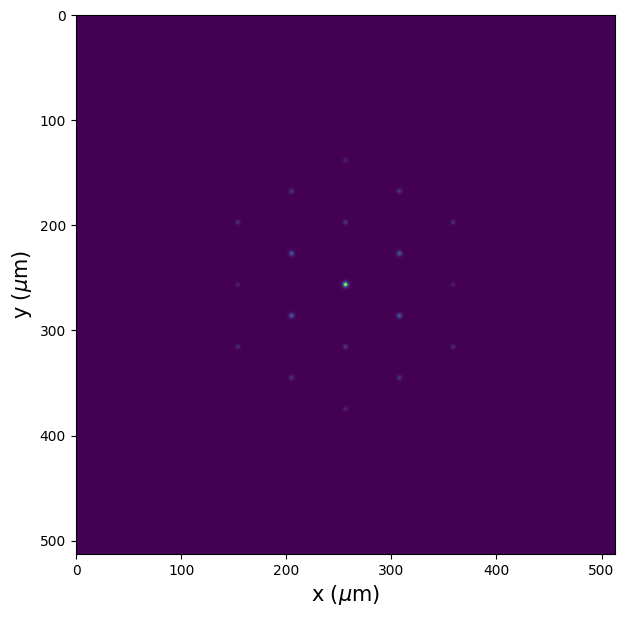

In [2]:
output_lantern = np.load('lantern_19port.npy')

plt.subplots(figsize=(7,7))
plt.imshow(np.abs(output_lantern)**2)
plt.xlabel(r'x ($\mu$m)', fontsize=15)
plt.ylabel(r'y ($\mu$m)', fontsize=15)

19 ports are a bit too much for this tutorial, so I will just select four of them to play around with: <br> 
port 0 - center, port 1 - bottom right, port 2 -top right, and port 3 - bottom center. <br>
I will crop and save their corresponding electric fields into 50x50 numpy arrays (1 $\mu$ m / pix).

[256.         307.27154088 307.27208857 256.        ]
[256.00152366 226.40351003 285.60398003 196.80021535]


(100.0, 400.0)

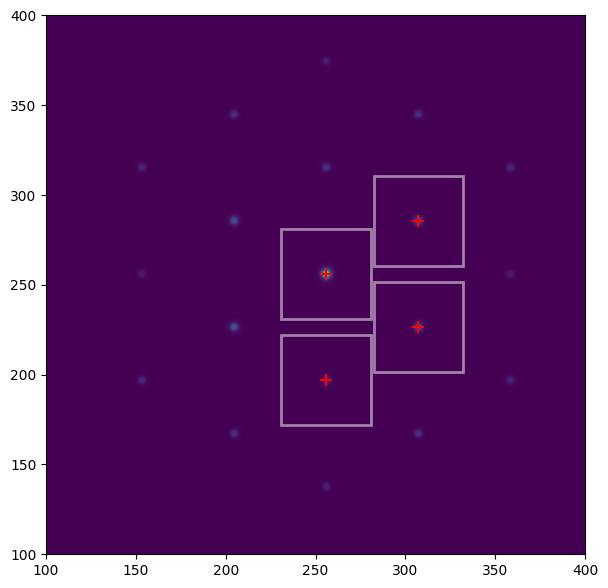

In [3]:
from photutils.centroids import centroid_com, centroid_sources
from photutils.utils import circular_footprint

#x_in = (0, 0, 0, 51e-6, 51e-6)
#y_in = (0, 60e-6, -60e-6, 30e-6, -30e-6)
x_in = (256, 310, 310, 256)
y_in = (259, 230, 290, 200)
footprint = circular_footprint(15.0)
x, y = centroid_sources(np.abs(output_lantern)**2, x_in, y_in, footprint=footprint, centroid_func=centroid_com)
print(x)
print(y)

#plot it
plt.subplots(figsize=(7,7))
plt.imshow(np.abs(output_lantern)**2)
plt.scatter(x, y, marker='+', s=80, color='red', label='Centroids')
sq1 = plt.Rectangle((x[0]-25, y[0]-25), 50, 50, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
plt.gca().add_artist(sq1)
sq2 = plt.Rectangle((x[1]-25, y[1]-25), 50, 50, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
plt.gca().add_artist(sq2)
sq3 = plt.Rectangle((x[2]-25, y[2]-25), 50, 50, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
plt.gca().add_artist(sq3)
sq4 = plt.Rectangle((x[3]-25, y[3]-25), 50, 50, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
plt.gca().add_artist(sq4)
plt.xlim(100, 400)
plt.ylim(100, 400)

Text(0.5, 1.0, 'Port 3 - bottom center')

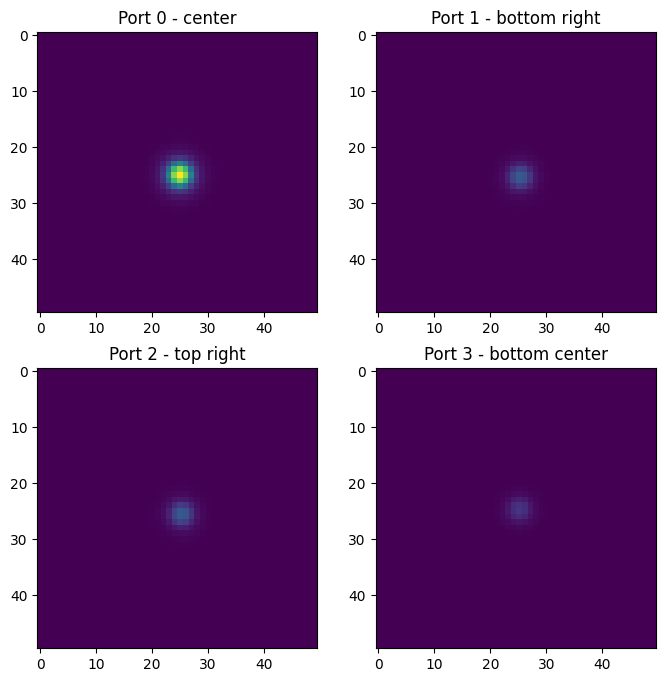

In [4]:
x0, y0 = int(np.rint(x[0])), int(np.rint(y[0]))
port_0 = output_lantern[x0-25 : x0+25, y0-25:y0+25]
x1, y1 = int(np.floor(x[1])), int(np.rint(y[1]))
port_1 = output_lantern[y1-25 : y1+25, x1-25:x1+25]
x2, y2 = int(np.floor(x[2])), int(np.floor(y[2]))
port_2 = output_lantern[y2-25 : y2+25, x1-25:x2+25]
x3, y3 = int(np.rint(x[3])), int(np.rint(y[3]))
port_3 = output_lantern[y3-25 : y3+25, x3-25:x3+25]

zmin, zmax = np.min(np.abs(port_0)**2), np.max(np.abs(port_0)**2)
#plot the intensity of each port
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
ax1.imshow(np.abs(port_0)**2)
ax2.imshow(np.abs(port_1)**2, vmin=zmin, vmax=zmax)
ax3.imshow(np.abs(port_2)**2, vmin=zmin, vmax=zmax)
ax4.imshow(np.abs(port_3)**2, vmin=zmin, vmax=zmax)
ax1.set_title('Port 0 - center')
ax2.set_title('Port 1 - bottom right')
ax3.set_title('Port 2 - top right')
ax4.set_title('Port 3 - bottom center')

Now, I will convert each of them into an `HCIPy` `Wavefront` object. For that, I have defined the function `ef_to_wf`, which takes the complex electric field as a numpy array, converts it into an `HCIPy` `Field` and then into a `Wavefront`, for which we will need a grid to define it. <br>
Let's do that with all four ports and see what one of them looks like. I also print the total power in each port, just for reference.

Power in: port 0= 0.188519, port 1= 0.056055, port 2= 0.056055, port 3= 0.030467


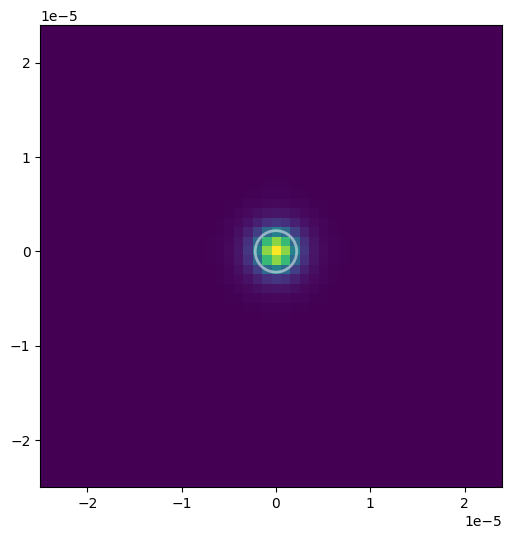

In [5]:
##I have saved the ports as individual EF np arrays, now convert them into HCIPy wavefronts
#assign a grid
wl = 1.55e-6 #wavelength
spatial_resolution = 1e-6 
port_grid = hc.make_uniform_grid([50, 50], [spatial_resolution*50, spatial_resolution*50], center=[-0.5e-6, -0.5e-6])

#use numpy EF of each port and convert into HCIPy Wavefront
port_0_wf = ef_to_wf(port_0.ravel(), port_grid, wavelength=wl)
port_1_wf = ef_to_wf(port_1.ravel(), port_grid, wavelength=wl)
port_2_wf = ef_to_wf(port_2.ravel(), port_grid, wavelength=wl)
port_3_wf = ef_to_wf(port_3.ravel(), port_grid, wavelength=wl)

#plot one of the ports
fig, ax = plt.subplots(figsize=(6,6))
hc.imshow_field(port_0_wf.power)
circ1 = plt.Circle((0., 0.), 2.2e-6, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
plt.gca().add_artist(circ1)

print('Power in: port 0= {:.6f}, port 1= {:.6f}, port 2= {:.6f}, port 3= {:.6f}'.format(
    port_0_wf.total_power, port_1_wf.total_power, port_2_wf.total_power, port_3_wf.total_power))

Okay, we have our individual ports as `Wavefront` objects, but now let's put them in a Single-Mode channel, *i.e.* a SM waveguide (or fiber), using the `HCIPy` class for a step-index fiber. The function `wf_to_smf` does this task, taking as input the parameters of the waveguide. Let's set the parameters of the fiber corresponding to those of the photonic lantern and put the light of each port into a waveguide. I print the power coupled into the individual waveguides, notice there is a small difference (~1\%). 

In [15]:
###define waveguide/SMF parameters
n_cladding = 1.4504
n_core = n_cladding + 0.01036
fiber_NA = np.sqrt(n_core**2 - n_cladding**2)
core_radius = 2.2e-6
fiber_length = 1

smf = hc.StepIndexFiber(core_radius, fiber_NA, fiber_length)
smf_0, smf_1, smf_2, smf_3 = [smf.forward(x) for x in [port_0_wf, port_1_wf, port_2_wf, port_3_wf]]
print('Power coupled: port 0= {:.6f}, port 1= {:.6f}, port 2= {:.6f}, port 3= {:.6f}'.format(
    smf_0.total_power, smf_1.total_power, smf_2.total_power, smf_3.total_power))
print('Initial phase in each beam: port 0= {:.6f}, port 1= {:.6f}, port 2= {:.6f}, port 3= {:.6f}'.format(
    smf_0.phase[0], smf_1.phase[0], smf_2.phase[0], smf_3.phase[0]))

Power coupled: port 0= 0.188519, port 1= 0.055041, port 2= 0.054200, port 3= 0.030370
Initial phase in each beam: port 0= -1.104895, port 1= -0.781416, port 2= -0.781416, port 3= -0.884266


#### Test - Port 0 (center) and port 2 (top right)
Now that we have our individual ports in waveguides, we can make them interfere and for that we need a directional coupler (DC). I won't go into detail on what a DC is, but basically it's a beamsplitter for waveguides/fibers and it works by putting the cores of two waveguides very close for a specific length, close enough for light to be able to transfer from one waveguide to the other. If you have only one input, light can be split into different output power ratios, cor ompletely transfered to the other waveguide. And if you have two input beams, you can combine them and make them interfere. <br>
How light is distributed will depend on the amplitudes and phases of the beams. What happens if we combine the two beams without any modifications to their phases? An ideal symmetric directional coupler (lossless) can be described through the matrix
$$ M = \begin{bmatrix} \cos(\kappa L) & i\sin(\kappa L) \\ i\sin(\kappa L) & \cos(\kappa L) \end{bmatrix}\, $$  
where $\kappa L $ is the product of the coupling constant and the coupling length of the directional coupler; depending on the latter, we can adjust the splitting ratio. For a 50/50 coupler, we set them so that both cos and sin are equal to $\sqrt(0.5)$. <br>
The function ```directional_coupler_sym``` performs this, so let's try it.

In [16]:
um = 1e-6
tot_pow_in = smf_0.total_power + smf_2.total_power
###Calling the directional coupler
out_1a, out_1b = directional_coupler_sym(smf_0, smf_2)

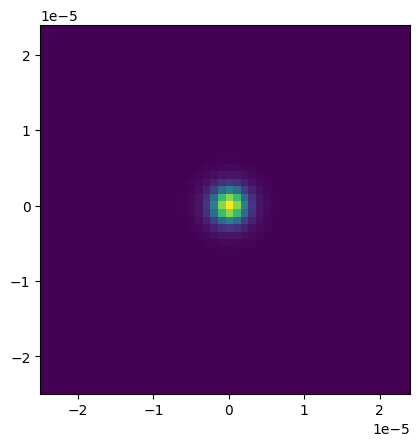

In [21]:
hc.imshow_field(out_1b.intensity)

Total power combined = 0.24272
Phase port 0 = -1.1049, port 3 = -0.7814


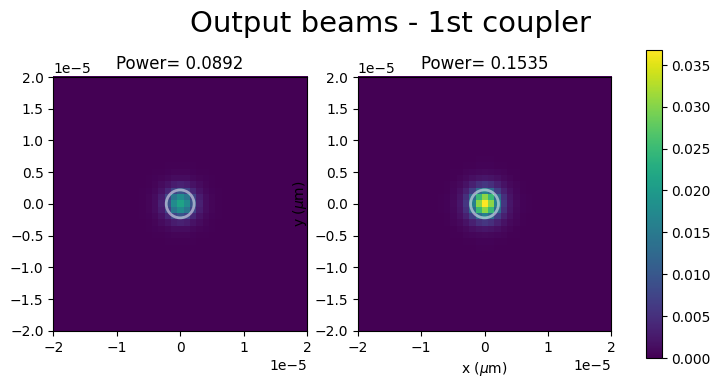

In [7]:
um = 1e-6
tot_pow_in = smf_0.total_power + smf_2.total_power
###Calling the directional coupler
out_1a, out_1b = directional_coupler_sym(smf_0, smf_2)

zmin = np.min([out_1a.power/ tot_pow_in, out_1b.power / tot_pow_in])
zmax = np.max([out_1a.power/ tot_pow_in, out_1b.power / tot_pow_in])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle('Output beams - 1st coupler', fontsize=21)
im1 = hc.imshow_field(out_1a.power/ tot_pow_in, ax=ax1, vmin = zmin, vmax= zmax)
circ = plt.Circle((0, 0), core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
ax1.add_artist(circ)
plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'y ($\mu$m)')
ax1.set_xlim(-20*um, 20*um)
ax1.set_ylim(-20*um, 20*um)
ax1.set_title('Power= {:.4f}'.format(out_1a.total_power))


im2 = hc.imshow_field(out_1b.power / tot_pow_in, ax=ax2, vmin = zmin, vmax= zmax)
circ = plt.Circle((0, 0), core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
ax2.add_artist(circ)
plt.xlabel(r'x ($\mu$m)')
ax2.set_xlim(-20*um, 20*um)
ax2.set_ylim(-20*um, 20*um)
ax2.set_title('Power= {:.4f}'.format(out_1b.total_power))
cb = fig.colorbar(im2, ax=(ax1, ax2), orientation='vertical')  

print('Total power combined = {:.5f}'.format(tot_pow_in))
print('Phase port 0 = {:.4f}, port 3 = {:.4f}'.format(smf_0.phase[0], smf_2.phase[0]))

As I mentioned, the splitting ratio will depend on the amplitude-phase properties of the input beams. Something that I noticed is that if the beams have different amplitudes and different initial phases and you map the phase difference from 0 to 2$\pi$, there will be no complete constructive/destructive interference, i.e., all light will not be transferred to one single output channel, a small portion of the light will remain in one of the outputs always. Let's take a look at that:

Phase  port 0 = -0.3517, port 2 = -0.2487


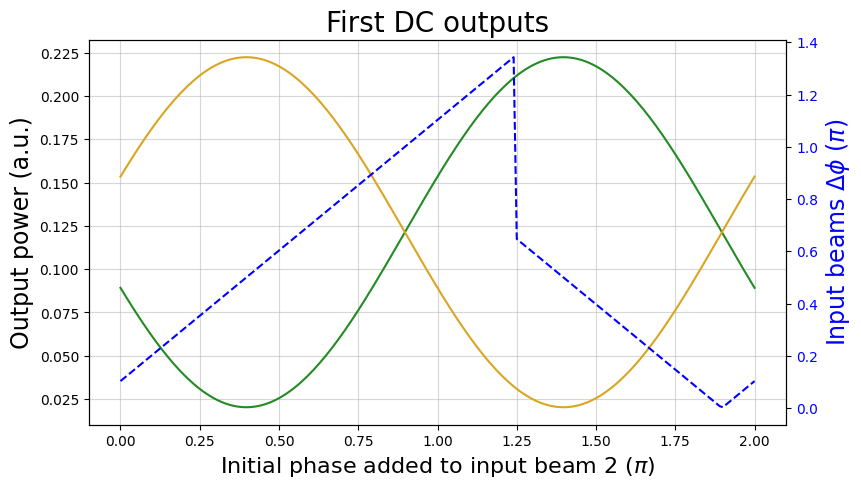

In [9]:
dphi = np.linspace(0.0, 2.0 * np.pi, num=201)

power_out_1a = np.array([])
power_out_1b = np.array([])
phase_diff_in = np.array([])
for i in range(len(dphi)):
    smf_2_dphi = hc.Wavefront(smf_2.electric_field * np.exp(1j * dphi[i]), wavelength=wl)
    out_1a, out_1b = directional_coupler_sym(smf_0, smf_2_dphi)
    power_out_1a = np.append(power_out_1a, out_1a.total_power)
    power_out_1b = np.append(power_out_1b, out_1b.total_power)
    phase_diff_in = np.append(phase_diff_in, np.abs(smf_0.phase[0] - smf_2_dphi.phase[0]))
    
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(dphi/np.pi, power_out_1a, c='forestgreen')
ax1.plot(dphi/np.pi, power_out_1b, c='goldenrod')
ax2.plot(dphi/np.pi, phase_diff_in/np.pi, linestyle='dashed', c='blue')
ax1.set_xlabel(r'Initial phase added to input beam 2 ($\pi$)', fontsize=16)
ax1.set_ylabel('Output power (a.u.)', fontsize=17)
ax2.set_ylabel(r'Input beams $\Delta\phi$ ($\pi$)', fontsize=17, c='blue')
ax2.tick_params(axis="y", labelcolor='blue')
ax1.set_title(r'First DC outputs', fontsize=20)
ax1.grid(True, alpha=0.5)
print('Phase  port 0 = {:.4f}, port 2 = {:.4f}'.format(smf_0.phase[0]/np.pi, smf_2.phase[0]/np.pi))

If we want 100\% constructive/destructive interference, we will need a second DC and use the first one to match the amplitudes (equal amounts of power in each output). First, we match the phases of the input beams so that the first DC splits the light in a 50/50 ratio. 

Input beams phase: beam 1 = -1.10490, beam 2 = -1.10490


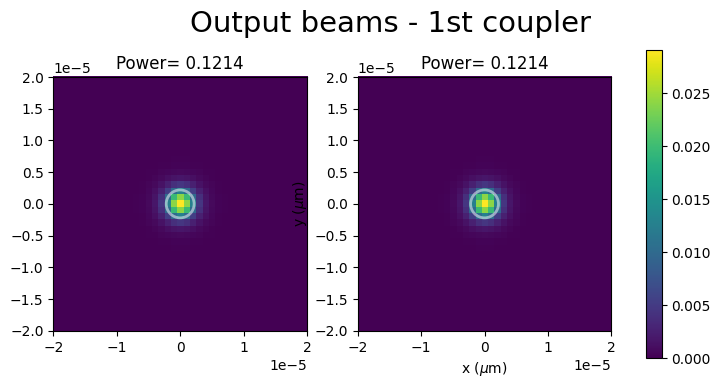

In [10]:
#add to the second input beam the phase difference required to match its phase to the other one 
diff = smf_0.phase[0] - smf_2.phase[0] + 2*np.pi
smf_2_comp = hc.Wavefront(smf_2.electric_field * np.exp(1j * diff), wavelength=wl)

#call the DC
out_1a, out_1b = directional_coupler_sym(smf_0, smf_2_comp)

zmin = np.min([out_1a.power/ tot_pow_in, out_1b.power / tot_pow_in])
zmax = np.max([out_1a.power/ tot_pow_in, out_1b.power / tot_pow_in])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle('Output beams - 1st coupler', fontsize=21)
im1 = hc.imshow_field(out_1a.power/ tot_pow_in, ax=ax1, vmin = zmin, vmax= zmax)
circ = plt.Circle((0, 0), core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
ax1.add_artist(circ)
plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'y ($\mu$m)')
ax1.set_xlim(-20*um, 20*um)
ax1.set_ylim(-20*um, 20*um)
ax1.set_title('Power= {:.4f}'.format(out_1a.total_power))

im2 = hc.imshow_field(out_1b.power / tot_pow_in, ax=ax2, vmin = zmin, vmax= zmax)
circ = plt.Circle((0, 0), core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
ax2.add_artist(circ)
plt.xlabel(r'x ($\mu$m)')
ax2.set_xlim(-20*um, 20*um)
ax2.set_ylim(-20*um, 20*um)
ax2.set_title('Power= {:.4f}'.format(out_1b.total_power))
cb = fig.colorbar(im2, ax=(ax1, ax2), orientation='vertical')

print("Input beams phase: beam 1 = {:.5f}, beam 2 = {:.5f}".format(smf_0.phase[0], smf_2_comp.phase[0]))


Now, that we have matched the amplitudes of the outputs, let's recombine these outputs adding a phase shift (map 0 to 2$\pi$) to the second beam before the second DC.

Phase  port 0 = -0.1950, port 2 = -0.0084


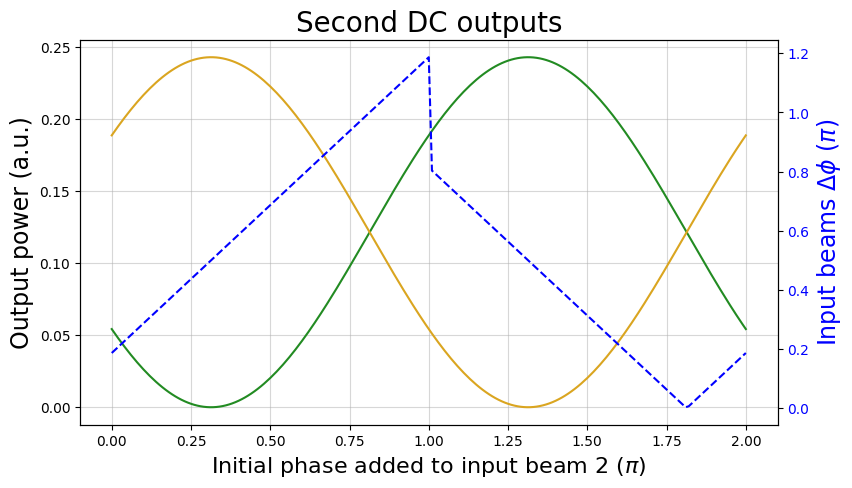

In [11]:
dphi = np.linspace(0.0, 2.0 * np.pi, num=201)

power_out_2a = np.array([])
power_out_2b = np.array([])
phase_diff_in = np.array([])
for i in range(len(dphi)):
    out_1b_dphi = hc.Wavefront(out_1b.electric_field * np.exp(1j * dphi[i]), wavelength=wl)
    out_2a, out_2b = directional_coupler_sym(out_1a, out_1b_dphi)
    power_out_2a = np.append(power_out_2a, out_2a.total_power)
    power_out_2b = np.append(power_out_2b, out_2b.total_power)
    phase_diff_in = np.append(phase_diff_in, np.abs(out_1a.phase[0] - out_1b_dphi.phase[0]))
    
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(dphi/np.pi, power_out_2a, c='forestgreen')
ax1.plot(dphi/np.pi, power_out_2b, c='goldenrod')
ax2.plot(dphi/np.pi, phase_diff_in/np.pi, linestyle='dashed', c='blue')
ax1.set_xlabel(r'Initial phase added to input beam 2 ($\pi$)', fontsize=16)
ax1.set_ylabel('Output power (a.u.)', fontsize=17)
ax2.set_ylabel(r'Input beams $\Delta\phi$ ($\pi$)', fontsize=17, c='blue')
ax2.tick_params(axis="y", labelcolor='blue')
ax1.set_title(r'Second DC outputs', fontsize=20)
ax1.grid(True, alpha=0.5)
print('Phase  port 0 = {:.4f}, port 2 = {:.4f}'.format(out_1a.phase[0]/np.pi, out_1b.phase[0]/np.pi))

Notice there is constructive/destrucive interference when the phase difference between the input beams is $\Delta\phi = \pi/2 + n\pi$ <br>
So, we need a second phase shifter between the first and the second directional coupler if we want to see all of the light going into one output and no light on the other one. If we put these elements together - 1st DC, phase shifter, 2nd DC - we have a Mach-Zehnder Interferometer. <br>
The function ```MZI_total``` puts together a phase shifter, the 1st DC, another phase shifter, and the 2nd DC. It makes the required phase adjustments (unless indicated otherwise) between the input beams and the output beams of the 1st DC to have constructive/destrucive interference. <br>
Let's use it with two different ports, 1 and 3.

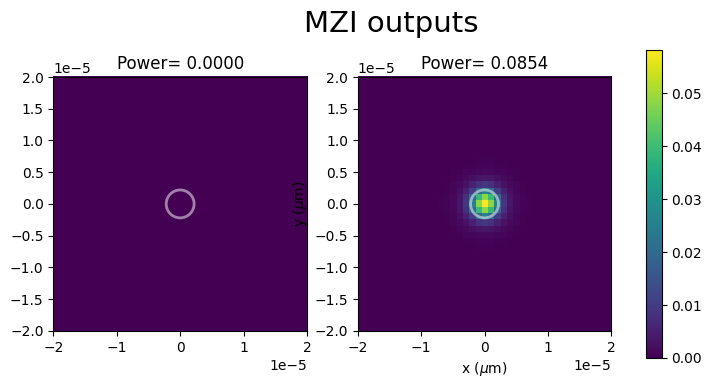

In [13]:
test2_a, test2_b = MZI_total(smf_1, smf_3, out=2, add_phase=None)

tot_pow_in = smf_1.total_power + smf_3.total_power

zmin = np.min([test2_a.power/ tot_pow_in, test2_b.power / tot_pow_in])
zmax = np.max([test2_a.power/ tot_pow_in, test2_b.power / tot_pow_in])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle('MZI outputs', fontsize=21)
im1 = hc.imshow_field(test2_a.power/ tot_pow_in, ax=ax1, vmin = zmin, vmax= zmax)
circ = plt.Circle((0, 0), core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
ax1.add_artist(circ)
plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'y ($\mu$m)')
ax1.set_xlim(-20*um, 20*um)
ax1.set_ylim(-20*um, 20*um)
ax1.set_title('Power= {:.4f}'.format(test2_a.total_power))

im2 = hc.imshow_field(test2_b.power / tot_pow_in, ax=ax2, vmin = zmin, vmax= zmax)
circ = plt.Circle((0, 0), core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
ax2.add_artist(circ)
plt.xlabel(r'x ($\mu$m)')
ax2.set_xlim(-20*um, 20*um)
ax2.set_ylim(-20*um, 20*um)
ax2.set_title('Power= {:.4f}'.format(test2_b.total_power))
cb = fig.colorbar(im2, ax=(ax1, ax2), orientation='vertical')  

And we have constructive interference in output 1 and destructive interference in output 2. If ```out=2```, interference will be the opposite way. The ```add_phase``` parameter adds an additional phase shift to the second phase shifter so that total constructive/destructive interference doesn't not occur and makes the distribution of light on each output different, depending on the value of the phase added.